In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_val_score, RandomizedSearchCV

from sklearn.preprocessing import FunctionTransformer



In [40]:
crashes = pd.read_csv('C:/Users/angie/Desktop/group_project/Chicago-Crashes/data/Traffic_Crashes_-_Crashes.csv', low_memory=False)
people = pd.read_csv('C:/Users/angie/Desktop/group_project/Chicago-Crashes/data/Traffic_Crashes_-_People.csv', low_memory = False)
#vehicles = pd.reimport pandas as pd

In [41]:
X = crashes.drop(['MOST_SEVERE_INJURY','INJURIES_TOTAL', 'INJURIES_FATAL','INJURIES_INCAPACITATING',
                      'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT',
                      'INJURIES_NO_INDICATION', 'CRASH_RECORD_ID', 'CRASH_DATE', 'LATITUDE', 
                      'LONGITUDE','LOCATION'], axis=1)

In [42]:
df_list=[crashes, people]
for df in df_list:
    min_count =  int((20/100)*df.shape[0] + 1)
    df = df.dropna(axis=1, thresh=min_count, inplace=True)

In [43]:
people_mod = people.drop(['CITY', 'ZIPCODE','RD_NO'], axis =1)
crashes_mod = crashes.drop(['CRASH_DATE','RD_NO','REPORT_TYPE', 'DATE_POLICE_NOTIFIED', 'STREET_NO', 
              'STREET_DIRECTION', 'STREET_NAME', 'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL',
             'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT', 
             'INJURIES_NO_INDICATION', 'INJURIES_UNKNOWN'], axis =1)

In [44]:
people_crashes_df = people_mod.merge(crashes_mod, on='CRASH_RECORD_ID', how='left')

In [45]:
people_crashes_df['TARGET'] = people_crashes_df['INJURY_CLASSIFICATION'].map({np.nan: 0,
                                                      'NO INDICATION OF INJURY': 0,
                                                      'NONINCAPACITATING INJURY': 1,
                                                      'REPORTED, NOT EVIDENT': 1,
                                                      'INCAPACITATING INJURY': 2,
                                                      'FATAL': 3})

In [46]:
people_crashes_df['CRASH_YEAR']=pd.to_datetime(people_crashes_df['CRASH_DATE']).dt.year

In [47]:
# Drop nulls from BEAT_OF_OCCURRENCE
people_crashes_df.dropna(subset = ['BEAT_OF_OCCURRENCE'], inplace=True)

In [48]:
# Drop ages < 0 and ages = 0 for DRIVER
people_crashes_df.loc[people_crashes_df.AGE < 0, 'AGE'] = np.nan
people_crashes_df.loc[(people_crashes_df.AGE == 0) & (people_crashes_df.PERSON_TYPE == 'DRIVER'), 'AGE'] = np.nan
people_crashes_df.dropna(subset = ['AGE'], inplace=True)

In [49]:
# Drop POSTED_SPEED_LIMIT = 0 or not divisible by 5
people_crashes_df.loc[people_crashes_df.POSTED_SPEED_LIMIT == 0, 'POSTED_SPEED_LIMIT'] = np.nan
people_crashes_df.loc[(people_crashes_df.POSTED_SPEED_LIMIT % 5) != 0, 'POSTED_SPEED_LIMIT'] = np.nan
people_crashes_df.dropna(subset = ['POSTED_SPEED_LIMIT'], inplace=True)

In [50]:
X = people_crashes_df.drop(['NUM_UNITS', 'BEAT_OF_OCCURRENCE', 'PRIM_CONTRIBUTORY_CAUSE', 'DAMAGE', 'TRAFFICWAY_TYPE', 'FIRST_CRASH_TYPE', 'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'SEAT_NO', 'DRIVER_ACTION', 'EJECTION', 'PERSON_TYPE', 'SEX', 'SAFETY_EQUIPMENT', 'AGE', 'AIRBAG_DEPLOYED', 'PERSON_ID', 'CRASH_RECORD_ID', 'VEHICLE_ID', 'CRASH_DATE', 'LANE_CNT', 'DRIVERS_LICENSE_STATE', 
                            'LATITUDE', 'LONGITUDE', 'LOCATION', 'INJURY_CLASSIFICATION', 'TARGET', 'CRASH_TYPE'], axis=1)
y = people_crashes_df['TARGET']

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [52]:
# def seat_no_transformer(df):
#     df['SEAT_NO'][df.PERSON_TYPE == 'DRIVER'] = 1
#     df['SEAT_NO'].fillna(0, inplace=True)
#     return df

In [53]:
def dl_class_transformer(df):
    dl_classes = ['A', 'B', 'C', 'D', np.nan]
    df['DRIVERS_LICENSE_CLASS'].loc[df['DRIVERS_LICENSE_CLASS'].isin(dl_classes) == False] = 'OTHER'
    return df

In [54]:
# def beat_transformer(df):
#     df['BEAT_OF_OCCURRENCE'] = df['BEAT_OF_OCCURRENCE'].astype('string')
#     df['BEAT_OF_OCCURRENCE'] = df['BEAT_OF_OCCURRENCE'].apply(lambda x: x[:-4])
#     df.BEAT_OF_OCCURRENCE.dropna()
#     return df

In [55]:
def to_float_transformer(df):
    '''
    Ensure all columns are float, not int.
    '''
    for col in [df.select_dtypes('int64').columns]:
        df[col] = df[col].astype('float64')
    return df

In [56]:
def fill_categories(df):
    '''
    Fill null values with given value for 
    unknown values in that column.
    Drop all remaining nulls.
    '''
    df.fillna({'STATE':'XX', 
               # 'DRIVERS_LICENSE_STATE':'XX', # This col now dropped before train-test-split
               'DRIVERS_LICENSE_CLASS': 'D', # Most common; D = 'normal' drivers license for cars
               'EJECTION': 'UNKNOWN',
               'DRIVER_ACTION': 'UNKNOWN',
               'DRIVER_VISION': 'UNKNOWN',
               'PHYSICAL_CONDITION': 'UNKNOWN',
               'SAFETY_EQUIPMENT': 'USAGE_UNKNOWN',
               'AIRBAG_DEPLOYED': 'DEPLOYMENT_UNKNOWN',
               'SEX': 'UNKNOWN',
               'INTERSECTION_RELATED_I': 'N',
               'HIT_AND_RUN_I': 'N',
               'BAC_RESULT': 'TEST NOT OFFERED'
              }, inplace=True)
    return df

In [57]:
ohe_cols = list(X_train.select_dtypes('object').columns)
#ohe_cols.append('BEAT_OF_OCCURRENCE')

In [58]:
# OneHotEncode the columns as part of cleaning
# to avoid needing to separate numerical and categorical
# columns later
ohe_col_trans = ColumnTransformer(transformers=
                                     [('ohe', OneHotEncoder(drop='first', sparse=False), 
                                       ohe_cols)],
                                 remainder='passthrough')

In [59]:
# Apply all our cleaning functions, then finish with ohe
cleaning_pipeline = Pipeline(steps=[
#    ('seat_no', FunctionTransformer(seat_no_transformer)),
#     ('age', FunctionTransformer(age_transformer)),
#    ('beat', FunctionTransformer(beat_transformer)),
#     ('speed', FunctionTransformer(speed_limit_transformer)),
    ('license', FunctionTransformer(dl_class_transformer)),
    ('fill_cat', FunctionTransformer(fill_categories)),
    ('float', FunctionTransformer(to_float_transformer)),
    ('col_trains', ohe_col_trans)
])



**--------------SMOTE, LogisticRegression, Default params------------------------**

In [ ]:
X_train_cleaned = cleaning_pipeline.fit_transform(X_train)

In [ ]:
len(X_train_cleaned), len(y_train)

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train_cleaned, y_train)

In [ ]:
model_pipe = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('lr', LogisticRegression(random_state=42, max_iter = 100))
])

In [ ]:
model_pipe.fit(X_train, y_train)

In [ ]:
model_pipe.score(X_train, y_train)

In [ ]:
from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(model_pipe.steps[1][1], X_train, y_train)

In [ ]:
from sklearn.metrics import plot_confusion_matrix
cm = confusion_matrix(y_train, y_pred, normalize = 'true')
print(cm)
plot_confusion_matrix(model_pipe, X_train, y_train)

In [ ]:
from sklearn.model_selection import cross_validate

def print_cv_scores(pipe):
    
    # we pass in pipe to cross validate along with a feature list.
    results = cross_validate(pipe, X_train, 
                                   y_train, 
                                   return_train_score=True)
    
    print(results['train_score'])
    print(results['train_score'].mean())
    print('##############')
    print(results['test_score'])
    print(results['test_score'].mean())
    
print_cv_scores(model_pipe)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
precision_recall_fscore_support(y_train, y_pred, average='macro')



-----SMOTE, LogisticRegression, Solver: 'lbfgs', # of Iterations: 100, Weights: 'balanced'------

In [ ]:
X_train_cleaned = cleaning_pipeline.fit_transform(X_train)

In [ ]:
len(X_train_cleaned), len(y_train)

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train_cleaned, y_train)

In [ ]:
model_pipe = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('lr', LogisticRegression(random_state=42, solver = 'lbfgs', max_iter = 100, class_weight = 'balanced'))
])

In [ ]:
model_pipe.fit(X_train, y_train)

In [ ]:
model_pipe.score(X_train, y_train)

In [ ]:
precision_recall_fscore_support(y_train, y_pred, average='macro')

In [ ]:
# from sklearn.model_selection import cross_validate

# def print_cv_scores(pipe):
    
#     # we pass in pipe to cross validate along with a feature list.
#     results = cross_validate(pipe, X_train, 
#                                    y_train, 
#                                    return_train_score=True)
    
#     print(results['train_score'])
#     print(results['train_score'].mean())
#     print('##############')
#     print(results['test_score'])
#     print(results['test_score'].mean())
    
# print_cv_scores(model_pipe)



-----SMOTE, LogisticRegression, Solver: 'liblinear', # of Iterations: 100, Weights: 'balanced'------

In [22]:
X_train_cleaned = cleaning_pipeline.fit_transform(X_train)

C:\Users\angie\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-15-0180a3756dde>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DRIVERS_LICENSE_CLASS'].loc[df['DRIVERS_LICENSE_CLASS'].isin(dl_classes) == False] = 'OTHER'
C:\Users\angie\anaconda3\envs\learn-env\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

In [23]:
len(X_train_cleaned), len(y_train)

(627054, 627054)

In [24]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_cleaned, y_train)

In [25]:
model_pipe = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('lr', LogisticRegression(random_state=42, solver = 'liblinear', max_iter = 100, class_weight = 'balanced'))
])

In [ ]:
model_pipe.fit(X_res, y_res)

In [ ]:
model_pipe.score(X_res, y_res)

In [ ]:
precision_recall_fscore_support(y_res, y_pred, average='macro')

**----- XGBOOST, default params------**

In [22]:
from xgboost import XGBClassifier

In [23]:
X_train_cleaned = cleaning_pipeline.fit_transform(X_train)

C:\Users\angie\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-15-0180a3756dde>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DRIVERS_LICENSE_CLASS'].loc[df['DRIVERS_LICENSE_CLASS'].isin(dl_classes) == False] = 'OTHER'
C:\Users\angie\anaconda3\envs\learn-env\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

In [24]:
len(X_train_cleaned), len(y_train)

(627054, 627054)

In [25]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_cleaned, y_train)

In [26]:
model_pipe = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('xgb', XGBClassifier(random_state=42, n_jobs = -1))
])

In [27]:
model_pipe.fit(X_res, y_res)

Pipeline(steps=[('ss', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=-1, num_parallel_tree=1,
                               objective='multi:softprob', random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [28]:
model_pipe.score(X_res, y_res)

0.8468345101097827

In [30]:
from sklearn.metrics import precision_recall_fscore_support

In [33]:
from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(model_pipe.steps[1][1], X_res, y_res)

In [34]:
precision_recall_fscore_support(y_res, y_pred, average='macro')

(0.837492389752786, 0.8417004613488416, 0.8355655358383325, None)

In [36]:
print(model_pipe.steps[1][1].feature_importances_)

[0.00254953 0.         0.00233605 0.00184723 0.00097822 0.00190925
 0.00063667 0.         0.00207959 0.00255143 0.         0.00347863
 0.00226279 0.019971   0.00513911 0.         0.00307888 0.00187971
 0.00106023 0.00102159 0.         0.001242   0.00136372 0.00363245
 0.00165718 0.0008518  0.         0.0026852  0.         0.00122229
 0.00111545 0.00087373 0.00911209 0.0021856  0.00044858 0.00141463
 0.00124821 0.00159017 0.         0.         0.         0.00283378
 0.00171399 0.         0.00199945 0.         0.00118223 0.00668535
 0.         0.00109466 0.00401093 0.00388916 0.00272809 0.01884322
 0.0045156  0.00133088 0.         0.00217315 0.00772509 0.0006892
 0.00263684 0.01616743 0.00812377 0.00607146 0.         0.00184517
 0.01411981 0.00183418 0.01307631 0.00462931 0.00542847 0.01481777
 0.00219632 0.00650142 0.00336755 0.06709845 0.01570165 0.0232122
 0.018059   0.00679315 0.00429122 0.00489835 0.00014759 0.00165096
 0.00513983 0.0291157  0.         0.00671592 0.00109376 0.003710

[[9.87447519e-01 1.17546461e-02 3.55984566e-04 4.41850190e-04]
 [1.65935318e-01 6.33055045e-01 1.81731015e-01 1.92786214e-02]
 [3.45698579e-02 1.59498974e-01 7.56740899e-01 4.91902693e-02]
 [1.45792674e-03 4.87108529e-03 4.11260561e-03 9.89558382e-01]]


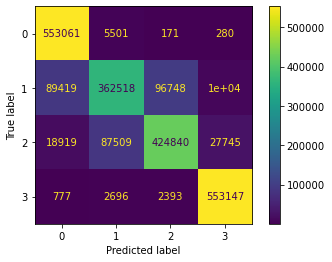

In [38]:
from sklearn.metrics import plot_confusion_matrix
cm = confusion_matrix(y_res, y_pred, normalize = 'true')
print(cm)
plot_confusion_matrix(model_pipe, X_res, y_res)

**----- ADASYN, DecisionTree, sampling_strategy = 'minority', n_neighbors = 5------**

In [60]:
X_train_cleaned = cleaning_pipeline.fit_transform(X_train)

C:\Users\angie\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-53-0180a3756dde>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DRIVERS_LICENSE_CLASS'].loc[df['DRIVERS_LICENSE_CLASS'].isin(dl_classes) == False] = 'OTHER'
C:\Users\angie\anaconda3\envs\learn-env\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

In [61]:
len(X_train_cleaned), len(y_train)

(627054, 627054)

In [62]:
ada = ADASYN(sampling_strategy = 'minority', random_state = 42, n_neighbors = 5)

NameError: name 'ADASYN' is not defined

In [ ]:
X_res, y_res = ada.fit_resample(X_train_cleaned, y_train)

In [ ]:
model_pipe = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('dtc', DecisionTreeClassifier(random_state=42, max_depth= 6, class_weight = 'balanced'))
])

In [ ]:
model_pipe.fit(X_res, y_res)

In [ ]:
model_pipe.score(X_res, y_res)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(model_pipe.steps[1][1], X_res, y_res)

In [ ]:
precision_recall_fscore_support(y_res, y_pred, average='macro')

**----- SMOTE, XGRegressor, default params------**

In [ ]:
from xgboost import XGBRegressor

In [ ]:
X_train_cleaned = cleaning_pipeline.fit_transform(X_train)

In [ ]:
len(X_train_cleaned), len(y_train)

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_cleaned, y_train)

In [ ]:
model_pipe = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('xgb', XGBRegressor())
])

In [ ]:
model_pipe.fit(X_res, y_res)

In [ ]:
model_pipe.score(X_res, y_res)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(model_pipe.steps[1][1], X_res, y_res)

In [ ]:
precision_recall_fscore_support(y_res, y_pred, average='macro')